In [3]:
# 导入必要的库  Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math
import torch.nn as nn


from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LinearRegression
from collections import deque
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import LSTM,Dense,Dropout,SimpleRNN,Input,Conv1D,Activation,BatchNormalization,Flatten,Permute
from tensorflow.python import keras

from tensorflow.python.keras.layers import Layer

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Conv2D,Input,Conv1D
from tensorflow.keras.models import Model
from PIL import *

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns

from sklearn.decomposition import PCA


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

from scipy.fftpack import fft

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

## Prepare dataset

In [4]:
dataset = pd.read_excel("横波反演数据.xlsx",sheet_name='yq3') #加载数据  Data loading

In [5]:
dataset.head()

,DEPTH,CNL-中子,DEN-密度,GR-自然伽马,VP-纵波速度,RT-电阻率,VS-横波速度
0,983.000,20.0609,2.4719,123.2550,4346.883593,18.7471,2251.857894
1,983.125,20.1264,2.4725,118.0902,4363.655105,19.7677,2285.438354
2,983.250,20.5881,2.4778,116.9060,4388.370817,20.9765,2320.925873
3,983.375,20.9740,2.4838,118.7275,4392.734694,22.0833,2348.164726
4,983.500,21.0693,2.4860,121.2757,4376.593838,22.8056,2360.446719


In [6]:
dataset=dataset.iloc[:,1:7] #划分数据集  Partitioning the dataset

In [7]:
dataset['RT-电阻率']=np.log10(dataset['RT-电阻率']) #电阻率取对数刻度 The resistivity exhibits a certain correlation with shear waves under a logarithmic scale

In [8]:
dataset.head()

,CNL-中子,DEN-密度,GR-自然伽马,VP-纵波速度,RT-电阻率,VS-横波速度
0,20.0609,2.4719,123.2550,4346.883593,1.272934,2251.857894
1,20.1264,2.4725,118.0902,4363.655105,1.295956,2285.438354
2,20.5881,2.4778,116.9060,4388.370817,1.321733,2320.925873
3,20.9740,2.4838,118.7275,4392.734694,1.344064,2348.164726
4,21.0693,2.4860,121.2757,4376.593838,1.358042,2360.446719


In [9]:
colunms=['CNL-中子','DEN-密度','GR-自然伽马','VP-纵波速度','RT-电阻率']    #数据归一化处理  Data normalization
scaler=MinMaxScaler()
scaler1=MinMaxScaler()
for col in colunms:
    dataset[col]=scaler.fit_transform(dataset[col].values.reshape(-1,1))
dataset['VS-横波速度']=scaler1.fit_transform(dataset['VS-横波速度'].values.reshape(-1,1))    

In [10]:
dataset.head()

,CNL-中子,DEN-密度,GR-自然伽马,VP-纵波速度,RT-电阻率,VS-横波速度
0,0.360300,0.543305,0.639013,0.393186,0.219239,0.360524
1,0.362524,0.544669,0.582211,0.401810,0.232892,0.386598
2,0.378196,0.556717,0.569188,0.414518,0.248179,0.414153
3,0.391296,0.570357,0.589220,0.416762,0.261422,0.435302
4,0.394531,0.575358,0.617245,0.408463,0.269711,0.444839


In [11]:
x=dataset.loc[:,['VP-纵波速度','GR-自然伽马','DEN-密度','RT-电阻率','CNL-中子']]
y=dataset['VS-横波速度']

In [12]:
x.shape

(6297, 5)

In [13]:
x.head()

,VP-纵波速度,GR-自然伽马,DEN-密度,RT-电阻率,CNL-中子
0,0.393186,0.639013,0.543305,0.219239,0.360300
1,0.401810,0.582211,0.544669,0.232892,0.362524
2,0.414518,0.569188,0.556717,0.248179,0.378196
3,0.416762,0.589220,0.570357,0.261422,0.391296
4,0.408463,0.617245,0.575358,0.269711,0.394531


In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签   Showing Chinese labels
plt.rcParams['axes.unicode_minus']=False 

In [15]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=666,shuffle=False)#数据分割 Data segmentation

In [16]:
X_train.shape

(4407, 5)

In [17]:
y_train.shape

(4407,)

In [18]:
def windows(x,y,days):    #构造特征方程，滑动窗口处理数据  Construct the characteristic equation and process the data by sliding window
    features=[]
    targets=[]
    
    x=scaler.fit_transform(x.iloc[:,:])
    deq=deque(maxlen=days)
    for i in x:
        deq.append(list(i))
        if days==len(deq):
            features.append(list(deq))
            
            
    x=features[:]        
    targets=y.values[days-1:]
    
    
    return np.array(x),np.array(targets)

In [19]:
train_dataset,train_labels=windows(X_train,y_train,3)
test_dataset,test_labels=windows(X_test,y_test,3)

In [20]:
train_dataset.shape

(4405, 3, 5)

In [21]:
train1=np.expand_dims(train_dataset,axis=3)#数据扩维  Data dimension extension
test1=np.expand_dims(test_dataset,axis=3)

In [22]:
train1.shape

(4405, 3, 5, 1)

In [23]:
# 3 构造批数据   Construct batch data

def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型   Data encapsulation
    if train: 
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else: 
        return batch_data.batch(batch_size)

In [24]:
# 训练批数据  Training batch data

train_batch_dataset = create_batch_dataset(train_dataset, train_labels)

In [25]:
# 测试批数据  Testing batch data

test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [52]:
class Attention_Conv2D(keras.layers.Layer):  #注意力机制 Attention mechanism
    def __init__(self, filters=None, num_heads=None, gamma=0.01, activation='relu', return_attention_scores=False, trainable=True):
        super().__init__(trainable=trainable)
        self.gamma = tf.Variable(initial_value=gamma, trainable=True, name='gamma')
        self.f = None
        self.g = None
        self.h = None
        self.v = None
        self.attention = None
        self.num_heads = num_heads
        self.c = filters
        self.activation = activation

    def build(self, input_shape):

        if self.c is None:
            self.c = input_shape[-1]

        if self.num_heads is None:
            self.num_heads = input_shape[-1]

        self.f = self.block(self.num_heads) # [n, w*h, heads]
        self.g = self.block(self.num_heads) # [n, w*h, heads]
        self.h = self.block(self.num_heads) # [n, w*h, heads]

        # output feature maps -> [n, w, h, filters]
        self.v = layers.Conv2D(self.c, 1, 1, activation=self.activation)

    @staticmethod
    def block(head):
        return keras.Sequential([
            layers.Conv2D(head, 1, 1),   # [n, w, h, heads] 1*1conv
            layers.Reshape((-1, head)),  # [n, w*h, heads]
            ])

    def call(self, inputs, **kwargs):
        f = self.f(inputs)    # [n, w*h, heads]
        g = self.g(inputs)    # [n, w*h, heads]
        h = self.h(inputs)    # [n, w*h, heads]
        s = tf.matmul(f, g, transpose_b=True)   # [n, w*h, heads] @ [n, heads, w*h] = [n, w*h, w*h]
        self.attention = tf.nn.softmax(s, axis=-1)
        context_wh = tf.matmul(self.attention, h)  # [n, w*h, w*h] @ [n, w*h, heads] = [n, w*h, heads]
        d = inputs.shape        # [n, w, h, channels]
        cs = context_wh.shape   # [n, w*h, heads]
        context = self.gamma * tf.reshape(context_wh, [-1, d[1], d[2], cs[-1]])    # [n, w, h, c]
        o = self.v(context) + inputs   # residual -> [n, w, h, filters]

        return tf.reshape(o,[-1,3,5,1])

In [53]:
def Bo_MA_BiLSTM():   #模型的构建  Construction of model
    inputs = Input(train1.shape[-3:])

    x=Attention_Conv2D(1, activation='relu', num_heads=32, return_attention_scores=True)(inputs)
    x=Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,5), padding="same",activation="relu")(x)  #, padding = 'same'
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (2,5), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
      
    lstm_out = tf.keras.layers.Bidirectional(LSTM(32,return_sequences=True,kernel_regularizer=keras.regularizers.l2(0.01)))(x[:,:,:,0])
    lstm_out = Dropout(0.1)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = tf.keras.layers.Bidirectional(LSTM(16,return_sequences=True,kernel_regularizer=keras.regularizers.l2(0.01)))(lstm_out)
    lstm_out = Dropout(0.1)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    attention_mul = Flatten()(lstm_out)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss=['MSE'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.004, beta_1=0.9),)
    return model

In [54]:
model6= Bo_MA_BiLSTM()

In [ ]:
# model6.save('path_to_my_model6.h5')

In [55]:
model6.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3, 5, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 3, 5, 32)     64          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 3, 5, 32)     64          input_3[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 15, 32)       0           conv2d_11[0][0]                  
____________________________________________________________________________________________

In [56]:
history2 = model6.fit(train_batch_dataset,
                    epochs=30,
                    validation_data=test_batch_dataset)

Epoch 1/30
35/35 [==============================] - ETA: 2:29 - loss: 1.594 - ETA: 2s - loss: 1.5317  - ETA: 1s - loss: 1.485 - ETA: 1s - loss: 1.446 - ETA: 1s - loss: 1.408 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.340 - ETA: 1s - loss: 1.307 - ETA: 1s - loss: 1.275 - ETA: 1s - loss: 1.244 - ETA: 1s - loss: 1.214 - ETA: 1s - loss: 1.184 - ETA: 1s - loss: 1.155 - ETA: 1s - loss: 1.127 - ETA: 1s - loss: 1.100 - ETA: 1s - loss: 1.073 - ETA: 1s - loss: 1.048 - ETA: 0s - loss: 1.023 - ETA: 0s - loss: 0.999 - ETA: 0s - loss: 0.976 - ETA: 0s - loss: 0.953 - ETA: 0s - loss: 0.931 - ETA: 0s - loss: 0.909 - ETA: 0s - loss: 0.888 - ETA: 0s - loss: 0.868 - ETA: 0s - loss: 0.848 - ETA: 0s - loss: 0.829 - ETA: 0s - loss: 0.811 - ETA: 0s - loss: 0.793 - ETA: 0s - loss: 0.775 - ETA: 0s - loss: 0.758 - ETA: 0s - loss: 0.742 - ETA: 0s - loss: 0.726 - ETA: 0s - loss: 0.711 - 7s 88ms/step - loss: 0.7048 - val_loss: 0.1891
Epoch 2/30
35/35 [==============================] - ETA: 1s - loss: 0.181 - ETA: 

Epoch 10/30
35/35 [==============================] - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - 2s 60ms/step - loss: 0.0069 - val_loss: 0.0242
Epoch 11/30
35/35 [==============================] - ETA: 1s - loss: 0.011 - ETA: 1s

Epoch 27/30
35/35 [==============================] - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 2s 62ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 28/30
35/35 [==============================] - ETA: 1s - loss: 0.012 - ETA: 1s

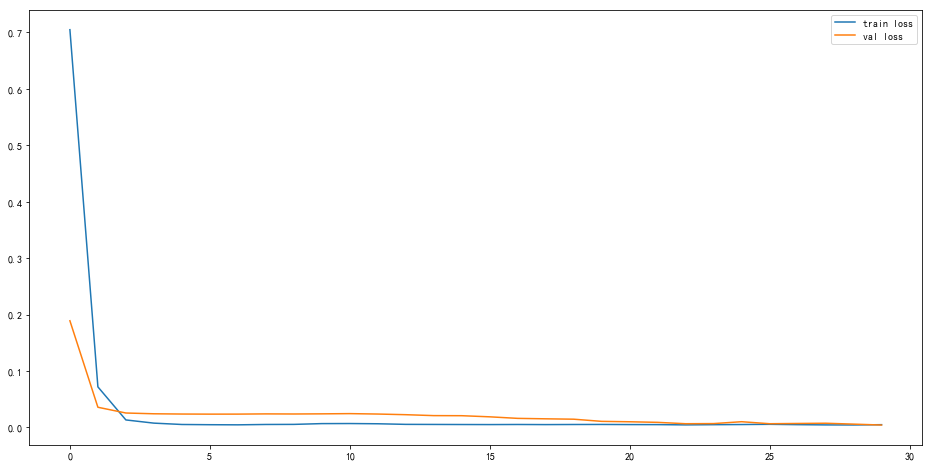

In [64]:
plt.figure(figsize=(16,8))
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [66]:
train_labels_test=scaler1.inverse_transform(train_labels.reshape(-1,1))#数据反归一化处理  Data inverse normalization processing

In [235]:
test_labels_test=scaler1.inverse_transform(test_labels.reshape(-1,1))

In [221]:
pred6 = model6.predict(train1)

In [222]:
pred = scaler1.inverse_transform(pred6)
# df = pd.DataFrame(pred1)
# df.to_excel('横波数据反演导出数据_Bo-MA 0.9104.xlsx', sheet_name='Sheet1')

In [223]:
score1=r2_score(train_labels,pred6)
print('r^2值为：',score1)

r^2值为： 0.9104763639004075


In [224]:
pred_test1 = model6.predict(test1)

In [233]:
pred_test = scaler1.inverse_transform(pred_test1)

In [236]:
score2=r2_score(test_labels_test,pred_test)
print('r^2值为：',score2)

r^2值为： 0.8480168386706733


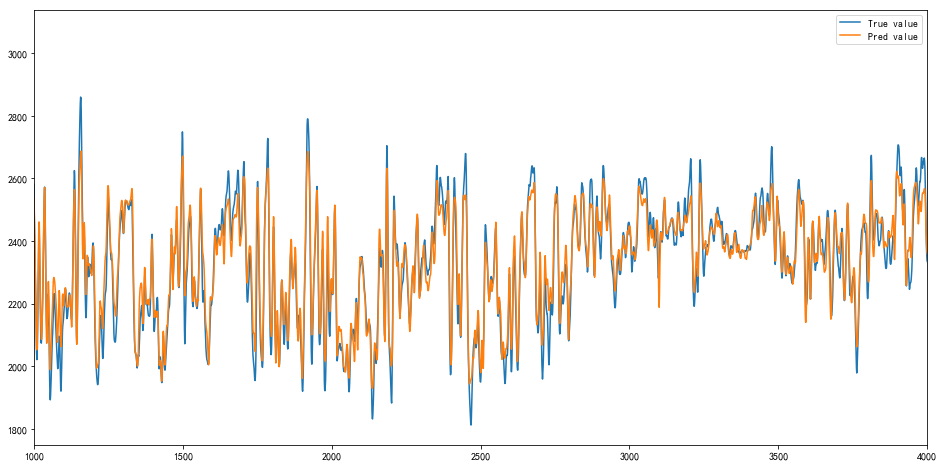

r^2值为： 0.9104763639004075


In [227]:
plt.figure(figsize=(16,8))
plt.plot(train_labels_test,label="True value")
plt.plot(pred,label="Pred value")
plt.xlim(1000,4000)
plt.legend(loc='best')
plt.show()
r2_score(pred,train_labels_test)
# plt.savefig('Bilstm_0.9148.png') 
print('r^2值为：',score1)

In [237]:
b1,b0 = np.polyfit(pred.ravel(),train_labels_test.ravel(),1)
# b2,b3 = np.polyfit(pred_test.ravel(),test_labels_test.ravel(),1)

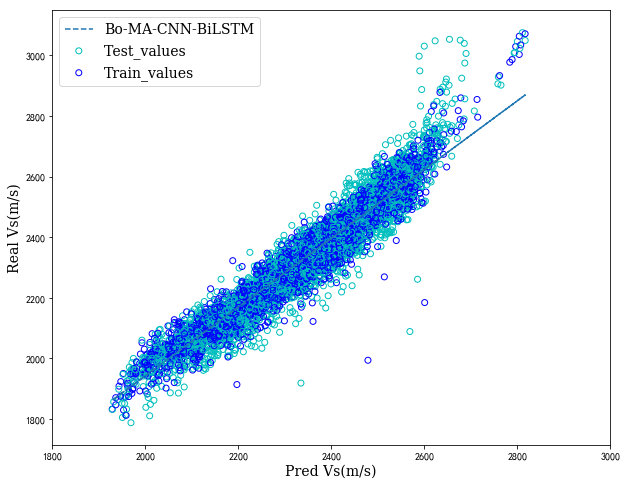

-160.75214843449783


In [252]:
font = {
    'family':'serif',
    'weight':'normal',
    'size':14,
}

legend_font = {
    'family':'serif',
    'weight':'normal',
    'size':14,
}


plt.figure(figsize=(10,8))
plt.plot(pred, b0 + b1*pred,linestyle='dashed',label = 'CNN-Lstm')
plt.scatter(pred_test, test_labels_test,c='none',marker='o',edgecolors='c',label = 'Test_values')
plt.scatter(pred, train_labels_test,c='none',marker='o',edgecolors='bc',label = 'Train_values')
# plt.scatter(2000, 2000,c='none',marker='o',edgecolors='c',label = 'Train_values')
plt.legend(loc=1)
plt.xlabel('Pred Vs(m/s)',font)
plt.ylabel('Real Vs(m/s)',font)
plt.xlim(1800,3000)
# plt.savefig('模型预测值与真实值的相关性分析_BO-MA.png')   # Analysis of correlation between predicted values and ground truth in the model
plt.legend(['Bo-MA-CNN-BiLSTM','Test_values','Train_values'],prop = legend_font,loc='upper left')
plt.show()
score=r2_score(b0 + b1*pred,train_labels)
print(score)

In [69]:
# model.save(r'model_data/model.h5')

In [93]:
# 模型搭建--版本1    #构建其它模型结构 Developing alternative model architectures

model = Sequential([
    layers.LSTM(units=256, input_shape=train_dataset.shape[-2:], return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=256, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=32),
    layers.Dense(1)
])

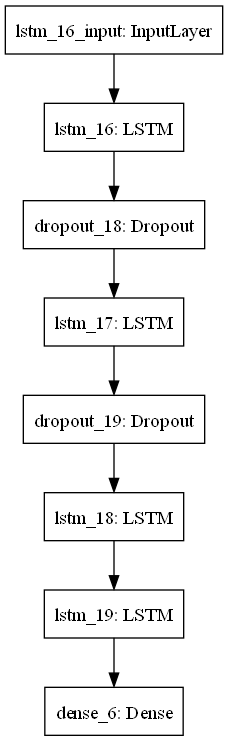

In [94]:
utils.plot_model(model)

In [95]:
model.compile(optimizer='adam',
              loss='mse')

In [96]:
history = model.fit(train_batch_dataset,
                    epochs=30,
                    validation_data=test_batch_dataset)

Epoch 1/30
35/35 [==============================] - ETA: 2:06 - loss: 0.182 - ETA: 0s - loss: 0.1645  - ETA: 0s - loss: 0.155 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.130 - ETA: 0s - loss: 0.124 - ETA: 0s - loss: 0.116 - ETA: 0s - loss: 0.108 - ETA: 0s - loss: 0.097 - ETA: 0s - loss: 0.090 - 5s 43ms/step - loss: 0.0859 - val_loss: 0.0462
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.056 - ETA: 0s - loss: 0.047 - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.029 - 1s 18ms/step - loss: 0.0291 - val_loss: 0.0238
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.021 - 1s 18ms/step - loss: 0.021

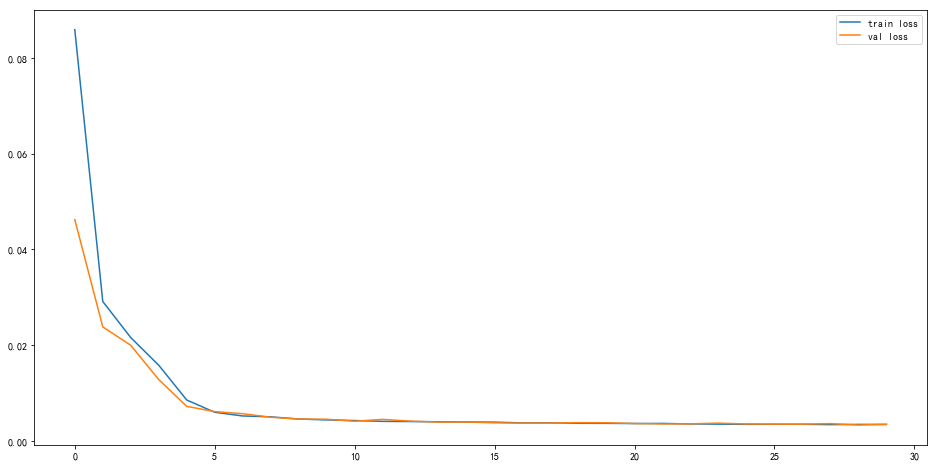

In [97]:
# 显示训练结果

plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [98]:
test_preds = model.predict(test_dataset, verbose=1)

59/59 [==============================] - ETA: 47 - ETA: 0 - ETA:  - 1s 2ms/step


In [99]:
score = r2_score(test_labels, test_preds)

print("r^2 值为： ", score)

r^2 值为：  0.851080138138993


In [126]:
def attention_model5():
    inputs = Input(train1.shape[-3:])

#     x=Attention_Conv2D(8, activation='relu', num_heads=8, return_attention_scores=True)(inputs)
#     x=Dropout(0.1)(x)
#     x = BatchNormalization()(x)
    x = Conv2D(100, (2,5), padding="same",activation="relu")(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(100, (2,5), padding="same",activation="relu")(x)  #, padding = 'same'
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(100, (2,5), padding="same",activation="relu")(x)  #, padding = 'same'
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss=['MSE'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9),)
    return model

In [127]:
model5 = attention_model5()

In [128]:
history2=model5.fit(train_batch_dataset,
                    epochs=30,
                    validation_data=test_batch_dataset)

Epoch 1/30
35/35 [==============================] - ETA: 13s - loss: 0.08 - ETA: 0s - loss: 0.0681 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.053 - ETA: 0s - loss: 0.047 - ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.030 - 1s 19ms/step - loss: 0.0285 - val_loss: 0.0246
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - 1s 16ms/step - loss: 0.0068 - val_loss: 0.0250
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - 1s 16ms/step - loss: 0.0066 - val_loss: 0.0241
Epoch 4/30
35/35 [==============================] - ET

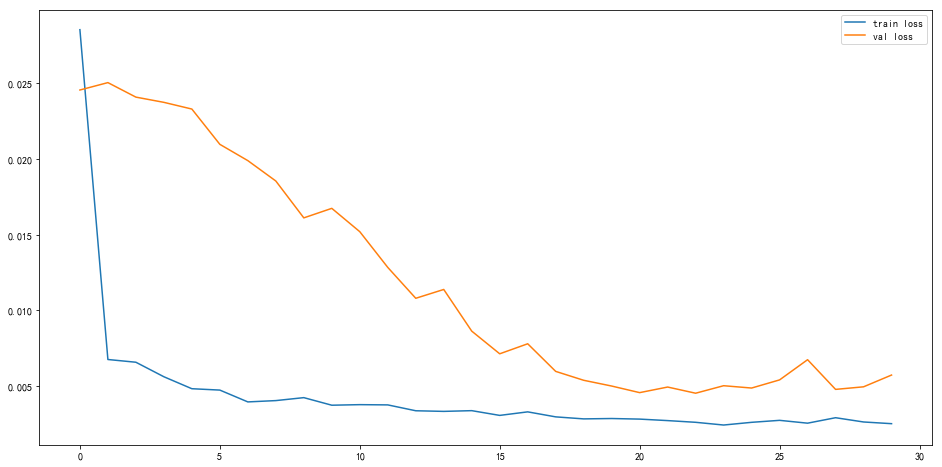

In [129]:
# 显示训练结果

plt.figure(figsize=(16,8))
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [130]:
pred_CNN = model5.predict(train1)

In [131]:
pred = scaler1.inverse_transform(pred_CNN)
# pred1= scaler1.inverse_transform(pred_CNN1)
# df = pd.DataFrame(pred1)
# df.to_excel('横波数据反演导出数据_CNN.xlsx', sheet_name='Sheet1')

In [132]:
score1=r2_score(train_labels,pred_CNN)
print('r^2值为：',score1)

r^2值为： 0.8235005131376235


In [144]:
def model_CNNLSTM():
    inputs = Input(train1.shape[-3:])
    
    x = Conv2D(50, (2,5), padding="same",activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(inputs)  #, padding = 'same'
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(100, (2,5), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    lstm_out = tf.keras.layers.LSTM(30,return_sequences=True)(x[:,:,:,0])
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    
    lstm_out = tf.keras.layers.LSTM(30,return_sequences=True,kernel_regularizer=keras.regularizers.l2(0.01))(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Flatten()(x)

    output = Dense(1, activation='sigmoid')(lstm_out)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss=['MSE'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9),)
    return model

In [145]:
model3 = model_CNNLSTM()

In [151]:
history4=model3.fit(train_batch_dataset,
                    epochs=30,
                    validation_data=test_batch_dataset)

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0079
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0091
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0076
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 5/30
35/35 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 6/30
35/35 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 0s 5ms/step - loss: 0.0024

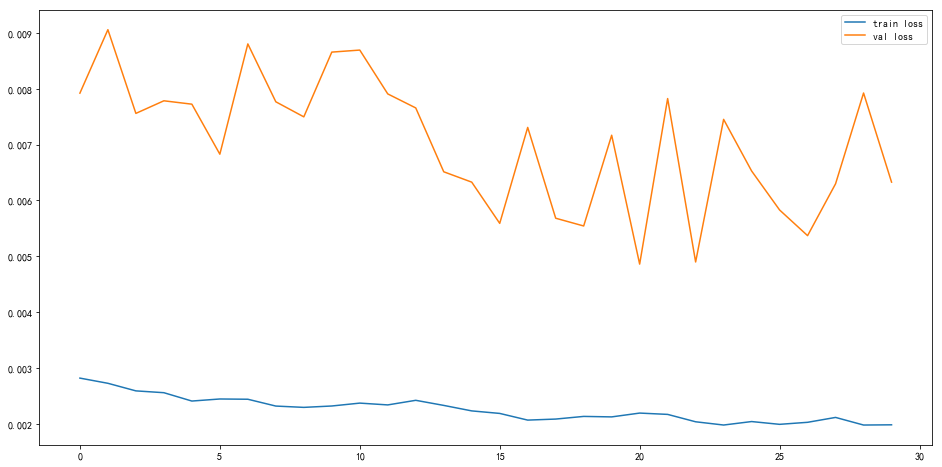

In [152]:
plt.figure(figsize=(16,8))
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [153]:
pred_CNNLSTM = model3.predict(train1)

In [155]:
score1=r2_score(train_labels,pred_CNNLSTM)
print('r^2值为：',score1)

r^2值为： 0.8681287043755835


In [213]:
# 模型搭建--版本1

model4 = Sequential([
    layers.Bidirectional(LSTM(units=256, input_shape=train_dataset.shape[-2:], return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(LSTM(units=256, input_shape=train_dataset.shape[-2:], return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(LSTM(units=256, input_shape=train_dataset.shape[-2:], return_sequences=True)),
    layers.LSTM(units=32),
    layers.Dense(1)
])

In [215]:
model4.compile(optimizer='adam',
              loss='mse')

In [216]:
history5 = model4.fit(train_batch_dataset,
                    epochs=30,
                    validation_data=test_batch_dataset)

Epoch 1/30
35/35 [==============================] - ETA: 2:23 - loss: 0.099 - ETA: 3s - loss: 0.0706  - ETA: 3s - loss: 0.064 - ETA: 3s - loss: 0.060 - ETA: 3s - loss: 0.059 - ETA: 3s - loss: 0.057 - ETA: 3s - loss: 0.055 - ETA: 2s - loss: 0.054 - ETA: 2s - loss: 0.052 - ETA: 2s - loss: 0.051 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.047 - ETA: 2s - loss: 0.046 - ETA: 2s - loss: 0.044 - ETA: 2s - loss: 0.043 - ETA: 2s - loss: 0.042 - ETA: 2s - loss: 0.041 - ETA: 1s - loss: 0.040 - ETA: 1s - loss: 0.039 - ETA: 1s - loss: 0.038 - ETA: 1s - loss: 0.037 - ETA: 1s - loss: 0.037 - ETA: 1s - loss: 0.036 - ETA: 1s - loss: 0.035 - ETA: 1s - loss: 0.034 - ETA: 1s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - 9s 155ms/step - loss: 0.0293 - val_loss: 0.0243
Epoch 2/30
35/35 [==============================] - ETA:

35/35 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 4s 112ms/step - loss: 0.0055 - val_loss: 0.0103
Epoch 18/30
35/35 [==============================] - ETA: 3s - loss: 0.

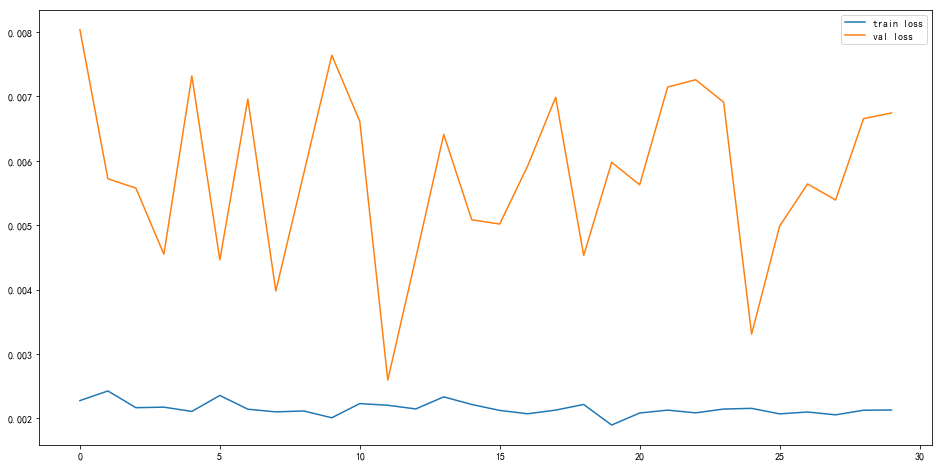

In [205]:
plt.figure(figsize=(16,8))
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [218]:
train_preds = model4.predict(train_dataset, verbose=1)

138/138 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 18ms/step


In [ ]:
score = r2_score(train_labels, train_preds)
print("r^2 值为： ", score)